In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define your folder structure
data_dir = '/content/drive/MyDrive/dataset'
classes = ['cats', 'dogs']

#Dataset source: https://www.kaggle.com/datasets/tongpython/cat-and-dog?resource=download-directory

VGG-19 Architecture

In [5]:
class VGG19(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG19, self).__init__()

        #Block 1: 2 Conv layers (64 filters), MaxPool
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        #Block 2: 2 Conv layers (128 filters), MaxPool
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        #Block 3: 4 Conv layers (256 filters), MaxPool
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        #Block 4: 4 Conv layers (512 filters), MaxPool
        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        #Block 5: 4 Conv layers (512 filters), MaxPool
        self.block5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        #Classifier (Fully Connected Layers)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 4096), # 224 -> 112 -> 56 -> 28 -> 14 -> 7
            nn.ReLU(inplace=True),
            nn.Dropout(0.5), #Dropout helps prevent overfitting
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes) #Final layer: N neurons
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.classifier(x)
        return x

In [6]:
def train_and_evaluate(model, train_loader, val_loader, epochs=5, lr=0.0001, model_name="Model"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_acc_history = []
    val_acc_history = []

    print(f"\n--- Training {model_name} ---")
    for epoch in range(epochs):
        #Training Phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_acc = 100 * correct / total
        train_acc_history.append(epoch_train_acc)

        #validation Phase
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_acc = 100 * val_correct / val_total
        val_acc_history.append(epoch_val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {running_loss/len(train_loader):.4f} | Train Acc: {epoch_train_acc:.2f}% | Val Acc: {epoch_val_acc:.2f}%")

    return train_acc_history, val_acc_history

Total images: 2023
Training set: 1618 images
Testing set: 405 images

--- Training VGG19 ---
Epoch [1/10] | Loss: 0.6944 | Train Acc: 48.95% | Val Acc: 49.63%
Epoch [2/10] | Loss: 0.6933 | Train Acc: 48.58% | Val Acc: 49.63%
Epoch [3/10] | Loss: 0.6935 | Train Acc: 50.06% | Val Acc: 50.37%
Epoch [4/10] | Loss: 0.6932 | Train Acc: 49.63% | Val Acc: 49.63%
Epoch [5/10] | Loss: 0.6933 | Train Acc: 48.52% | Val Acc: 50.37%
Epoch [6/10] | Loss: 0.6934 | Train Acc: 49.75% | Val Acc: 50.37%
Epoch [7/10] | Loss: 0.6936 | Train Acc: 49.69% | Val Acc: 49.63%
Epoch [8/10] | Loss: 0.6936 | Train Acc: 47.78% | Val Acc: 50.37%
Epoch [9/10] | Loss: 0.6934 | Train Acc: 49.26% | Val Acc: 49.63%
Epoch [10/10] | Loss: 0.6932 | Train Acc: 50.00% | Val Acc: 49.63%


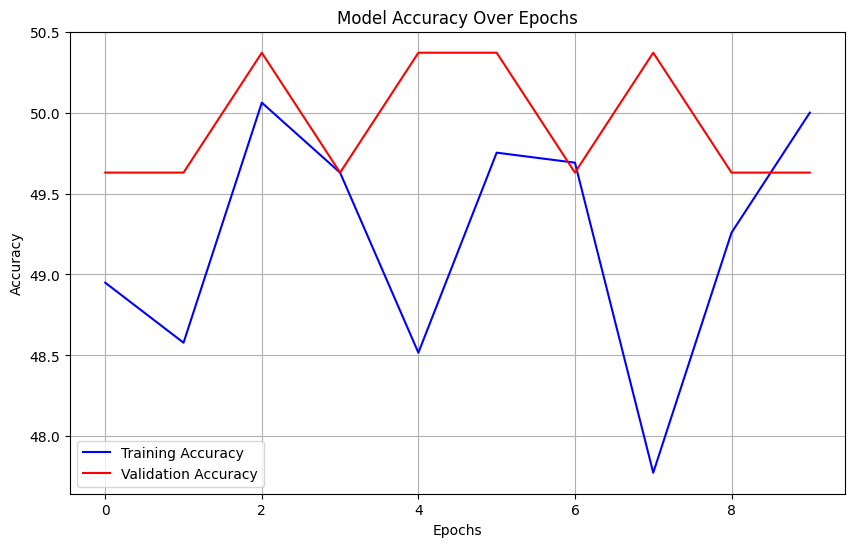

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = ImageFolder(root=data_dir, transform=transform)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Total images: {len(full_dataset)}")
print(f"Training set: {len(train_dataset)} images")
print(f"Testing set: {len(test_dataset)} images")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg19 = VGG19(num_classes=2).to(device)
train_history, val_history = train_and_evaluate(model_vgg19, train_loader, test_loader, epochs=10, model_name="VGG19")

plt.figure(figsize=(10, 6))
plt.plot(train_history, label='Training Accuracy', color='blue')
plt.plot(val_history, label='Validation Accuracy', color='red')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
torch.save(model_vgg19.state_dict(), 'vgg19.pth')
print("Model saved as vgg19.pth")

Model saved as vgg19.pth


**Part 3: Discussion**

*   Input layer: The Input layer acts as the entry
point for the network where in VGG-19 it accepts an image tensor of dimensions 224x224x3 it doesnt perform any learning but holds the raw pixel values for processing

* Hidden Layers: The hidden layers constitute the majority of the VGG-19 architecture (18 of the 19 layers). Their primary role is to transform the raw pixel data into abstract, meaningful information. In VGG-19, the hidden layers are divided into two distinct stages:



1.  Feature Extraction (Convolutional & Pooling Layers): The stack of convolutional layers identifies patterns ranging from simple edges to complex object shapes. The pooling layers interleaved here reduce the image size to make processing efficient and translation-invariant.
2. Classification/Reasoning (First two Fully Connected Layers): After flattening the features, the first two dense layers (4096 neurons each) act as the "brain" of the network. They interpret the high-level features extracted by the convolutional blocks to understand what object is present in the image


* Output Layer: The role of the output layer is to provide the final prediction. It consists of a fully connected layer with $N$ neurons (where $N$ is the number of classes, e.g., 2 for Cats vs. Dogs). It uses the Softmax activation function to convert the network's calculations into a probability distribution, where the sum of all values is 1. The neuron with the highest value represents the model's predicted class.

VGG-19 is famous for using small 3x3 filters throughout the entire network, rather than larger filters (like 7x7 or 11x11). The main reasons are:
1. Reduced Parameters: A stack of three 3x3 filters has the same effective receptive field as a single 7x7 filter but uses significantly fewer parameters ($27$ weights vs $49$ weights). This makes the model lighter and faster to train.
2. More Non-Linearity: By using a stack of three small layers instead of one large layer, we can insert a ReLU activation after every layer. This adds three non-linear decision boundaries instead of just one, allowing the network to learn much more complex features.
3. Capturing Detail: Small filters are better at capturing very fine, local details in an image, which is crucial for high-accuracy classification tasks.

Dataset: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
This dataset contains brain MRI images together with manual FLAIR abnormality segmentation masks.
The images were obtained from The Cancer Imaging Archive (TCIA).
They correspond to 110 patients included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available.

Number of Classes: **2 Classes (Binary Classification)**


*   Class 0 (No Tumor): MRI slices where the expert-labeled mask is empty (all black).


*   Class 1 (Tumor): MRI slices where the mask contains tumor tissue (white pixels).



Train-Test-Validation Split: The dataset was split using a **70% / 15% / 15%** ratio:

* Training Set: 2,750 images (Used to learn the weights).

* Validation Set: 590 images (Used to tune hyperparameters and check for overfitting).

* Test Set: 589 images (Used for the final performance evaluation).

**Unique Features:** Unlike standard classification datasets where images are labeled "cat" or "dog," the labels here are dynamically derived from segmentation masks.

In [ ]:
import os
import glob
import numpy as np
import kagglehub
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50, Xception, DenseNet121

BATCH_SIZE = 16
NUM_CLASSES = 2
LEARNING_RATE = 0.0001
EPOCHS = 10
IMG_SIZE = (224, 224)

gpus = tf.config.list_physical_devices('GPU')
print(f"Using device: {'GPU' if gpus else 'CPU'}")


print("Downloading dataset via kagglehub...")
path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")
print("Path to dataset files:", path)

possible_dir = os.path.join(path, 'kaggle_3m')
if os.path.isdir(possible_dir):
    DATA_DIR = possible_dir
else:
    DATA_DIR = path
print(f"Set DATA_DIR to: {DATA_DIR}")

def load_data_paths_and_labels(root_dir):
    image_paths = []
    labels = []

    # Recursive search for *_mask.tif
    search_path = os.path.join(root_dir, '**', '*_mask.tif')
    mask_files = glob.glob(search_path, recursive=True)

    if not mask_files:
        mask_files = glob.glob(os.path.join(root_dir, '*', '*_mask.tif'))

    if not mask_files:
        raise RuntimeError(f"No mask files found in {root_dir}. Check dataset structure.")

    print(f"Processing {len(mask_files)} files to generate labels...")

    for mask_path in mask_files:
        img_path = mask_path.replace('_mask.tif', '.tif')

        if os.path.exists(img_path):
            image_paths.append(img_path)

            with Image.open(mask_path) as m:
                if np.max(np.array(m)) > 0:
                    labels.append(1) # Tumor
                else:
                    labels.append(0) # No Tumor

    return np.array(image_paths), np.array(labels)

all_paths, all_labels = load_data_paths_and_labels(DATA_DIR)

# Split: 70% Train, 15% Val, 15% Test
train_paths, test_val_paths, train_labels, test_val_labels = train_test_split(
    all_paths, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    test_val_paths, test_val_labels, test_size=0.5, random_state=42, stratify=test_val_labels
)

print(f"Data Splitting Complete. Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

def process_image(file_path, label):
    """
    Loads and preprocesses a single image.
    Uses numpy() to fix the 'EagerTensor' decode error.
    """
    def _load_tif(path):
        path = path.numpy().decode('utf-8')

        img = Image.open(path).convert('RGB')
        img = img.resize(IMG_SIZE)
        return np.array(img, dtype=np.float32) / 255.0

    [image, ] = tf.py_function(_load_tif, [file_path], [tf.float32])
    image.set_shape([IMG_SIZE[0], IMG_SIZE[1], 3])
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = (image - mean) / std

    return image, label

def get_tf_dataset(paths, labels, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        data_augmentation = tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.04),
        ])
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = get_tf_dataset(train_paths, train_labels, shuffle=True, augment=True)
val_ds = get_tf_dataset(val_paths, val_labels, shuffle=False)
test_ds = get_tf_dataset(test_paths, test_labels, shuffle=False)

def get_model(model_name):
    print(f"\nInitializing {model_name}...")

    base_model = None
    if model_name == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'xception':
        base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'densenet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

    model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model_names = ['resnet50', 'xception', 'densenet121']
results = {}

for name in model_names:
    model = get_model(name)

    print(f"Training {name}...")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=1
    )

    print(f"Evaluating {name}...")
    y_pred_probs = model.predict(test_ds)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.concatenate([y for x, y in test_ds], axis=0)

    acc = accuracy_score(y_true, y_pred)
    results[name] = acc

    print(f"\n--- Performance Report for {name} ---")
    print(classification_report(y_true, y_pred, target_names=['No Tumor', 'Tumor']))


print("\nFinal Accuracy Comparison:")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")

Using device: GPU
Using Colab cache for faster access to the 'lgg-mri-segmentation' dataset.
Path to dataset files: /kaggle/input/lgg-mri-segmentation
Set DATA_DIR to: /kaggle/input/lgg-mri-segmentation/kaggle_3m
Processing 3929 files to generate labels...
Data Splitting Complete. Train: 2750, Val: 589, Test: 590

Initializing resnet50...
Training resnet50...
Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 141s 446ms/step - accuracy: 0.8237 - loss: 0.4008 - val_accuracy: 0.6503 - val_loss: 2.5776
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 57s 275ms/step - accuracy: 0.9483 - loss: 0.1468 - val_accuracy: 0.7131 - val_loss: 1.0881
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 56s 270ms/step - accuracy: 0.9522 - loss: 0.1494 - val_accuracy: 0.8557 - val_loss: 0.3702
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 55s 269ms/step - accuracy: 0.9725 - loss: 0.0870 - val_accuracy: 0.9117 - val_loss: 0.2197
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 56s 270ms/step - accuracy: 0.9768 - loss: 0.0661 - val_accuracy: 0.9626 -